In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import os
sys.path.append('../python/')

#set up matplotlib
os.environ['MPLCONFIGDIR'] = '../mplstyles'
print(os.environ['MPLCONFIGDIR'])
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')
print(mpl.__version__) 
print(mpl.get_configdir())


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])


#set up numpy
import numpy as np

../mplstyles
3.0.3
/home/phys/villaa/analysis/misc/nrFano_Constraint/mplstyles


# Summary

We know that the Dogherty paper [[Dough92][Dough92]] has measured the ionization variance for nuclear recoils in silicon. And that this paper has compared to results to the Lindhard description (J. Lindhard _et al_., Mat. Fys. Medd. K. Dan. Vidensk. Selsk **33**, 10 (1963)). The purpose of this note is to recast these results in terms of the effective Fano factor and make it clear where we got the information from, and how the data was processed. 

[Dough92]: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.45.2104 "Dougherty paper 1992"

# Extracting the Lindhard Function(s)

In the Lindhard reference above (J. Lindhard _et al_., Mat. Fys. Medd. K. Dan. Vidensk. Selsk **33**, 10 (1963)), Figure 8 contains the information we need and is reproduced below. 

<img src="pics/lindhard2_curves.png" alt="Lindhard ionization variance" style="width: 600px;"/>

The red and green curves report the fractional variance $(\Omega/\epsilon)^2$ in phonon (heat) energy produced by a nucleus with a given initial non-dimensionalized energy $\epsilon$. From the `pdf` file for the publication listed we extracted the curves by first using `inkscape` to draw colored Bezier curves over the curves of interest and then extracting the `svg` points for those curves from the resulting saved `svg` figure. 

For now instead of using the `svg` extraction, we are using `DataThief` to extract the colored curves. The results are shown below.

In [2]:
import dataPython as dp
import numpy as np

lind_data0 = dp.getXYdata('data/lindhard2_OmegaepsD_fmt.txt')
lind_data1 = dp.getXYdata('data/lindhard2_OmegaepsE_fmt.txt')

lindD_e = np.asarray(lind_data0['xx'])
lindD = np.asarray(lind_data0['yy'])
lindE_e = np.asarray(lind_data1['xx'])
lindE = np.asarray(lind_data1['yy'])

print(np.min(np.diff(lindD_e)))
print(np.min(np.diff(lindE_e)))

0.0
0.0


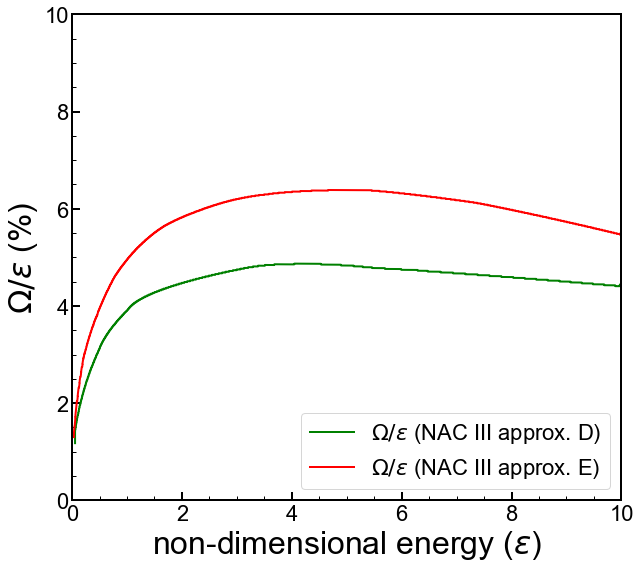

In [3]:
#set up a plot

fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

xmax=10

#ax1.errorbar(ddata_e,ddata_fluct,yerr=[ddata_fluct_err,ddata_fluct_err], marker='o', markersize=8, \
#             ecolor='k',color='k', linestyle='none', label='Dougherty Excess Fluctuation', linewidth=2)


#ax1.plot (X, diff, 'm-', label='Thomas-Fermi (newgrad)')
#ax1.plot (Esi(epr), 100*np.sqrt(f_Omega2_eta2(epr))*ylindv(1000*Esi(epr)), 'g-', label='$\Omega/\epsilon$ (NAC III approx. D)')
ax1.plot (lindD_e, np.sqrt(lindD)*100, 'g-', label='$\Omega/\epsilon$ (NAC III approx. D)')
ax1.plot (lindE_e, np.sqrt(lindE)*100, 'r-', label='$\Omega/\epsilon$ (NAC III approx. E)')




ax1.set_yscale('linear')
ax1.set_xscale('linear')
ax1.set_xlim(0.0, xmax)
ax1.set_ylim(0,10)
ax1.set_xlabel('non-dimensional energy ($\epsilon$)',**axis_font)
ax1.set_ylabel('$\Omega/\epsilon$ (%)',**axis_font)
#ax1.grid(True)
#ax1.xaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()



The next thing to do is to convert the non-dimensional energy $\epsilon$ into the recoil energy for silicon. The equation to do this comes from the Lindhard reference (J. Lindhard _et al_., Mat. Fys. Medd. K. Dan. Vidensk. Selsk **33**, 10 (1963)). 

\begin{equation}
E\,(\mathrm{keV}) = \frac{2\sqrt{2} \epsilon}{6.87758\times\mathrm{10}^{\mathrm{-2}}}
\end{equation}

In [4]:
Esi = np.vectorize(lambda x: np.sqrt(2)*2*x/(6.87758e-5*1000))

We also need to translate the $\Omega/\epsilon$ into an effective Fano factor. Typically, for each event the non-dimensionalized ionization and phonon energy released are denoted $\eta$ and $\nu$ respectively. Since they add to $\epsilon$, we have:

\begin{equation}
\epsilon = \nu + \eta.
\end{equation}

This means that since $\Omega^2$ is the variance in $\nu$ it is also the variance in $\eta$. That means that the expression:

\begin{equation}
\frac{\Omega}{\eta} 
\end{equation}

is equal to the fractional width of the ionization energy produced in the interaction. It is therefore equal to:

\begin{equation}
\frac{\sigma_N}{N},
\end{equation}

where N is the number of electron-hole pairs produced in an interaction. Since the effective Fano factor has $\sigma_N$ parameterized as $\sqrt{FN}$, we can use the above equality to find that:

\begin{equation}
F = N\left(\frac{\epsilon}{\eta}\right)^2\left(\frac{\Omega}{\epsilon} \right)^2.
\end{equation}

If we re-arrange using the ionization yeild as a function of recoil energy, $Y(E_r)$ we would get:

\begin{equation}
F = \frac{\epsilon}{\epsilon_{\gamma}Y(E_r)} \left(\frac{\Omega}{\epsilon}\right)^2.
\end{equation}

In [5]:
#create a yield model
import lindhard as lind

#lindhard
lpar = lind.getLindhardPars('Si',True) #use the "calculated" value of k
print(lpar)
#ylind = lind.getLindhard(lpar)
ylind = lind.getLindhardSi_k(0.15)
ylindv = np.vectorize(ylind) #careful, this expects inputs in eV

{'Z': 14, 'A': 28, 'k': 0.14600172346755985, 'a': 3.0, 'b': 0.15, 'c': 0.7, 'd': 0.6}


In [6]:
#convert the vectors
epsg = 3.8e-3 #keV average energy per electron-hole pair created


F_D = Esi(lindD_e)*(1/(epsg*ylindv(1000*Esi(lindD_e))))*lindD
F_E = Esi(lindE_e)*(1/(epsg*ylindv(1000*Esi(lindE_e))))*lindE

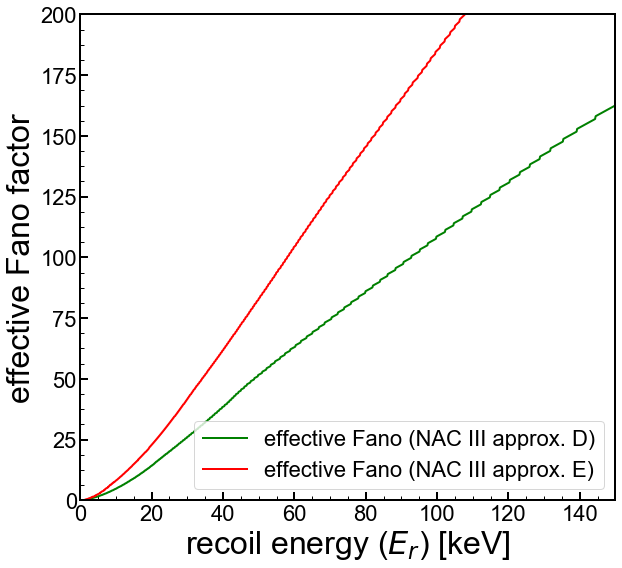

In [7]:
#set up a plot

fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

xmax=10

#ax1.errorbar(ddata_e,ddata_fluct,yerr=[ddata_fluct_err,ddata_fluct_err], marker='o', markersize=8, \
#             ecolor='k',color='k', linestyle='none', label='Dougherty Excess Fluctuation', linewidth=2)


#ax1.plot (X, diff, 'm-', label='Thomas-Fermi (newgrad)')
#ax1.plot (Esi(epr), 100*np.sqrt(f_Omega2_eta2(epr))*ylindv(1000*Esi(epr)), 'g-', label='$\Omega/\epsilon$ (NAC III approx. D)')
ax1.plot (Esi(lindD_e), F_D, 'g-', label='effective Fano (NAC III approx. D)')
ax1.plot (Esi(lindE_e), F_E, 'r-', label='effective Fano (NAC III approx. E)')




ax1.set_yscale('linear')
ax1.set_xscale('linear')
ax1.set_xlim(Esi(0), 150)
ax1.set_ylim(0,200)
ax1.set_xlabel('recoil energy ($E_r$) [keV]',**axis_font)
ax1.set_ylabel('effective Fano factor',**axis_font)
#ax1.grid(True)
#ax1.xaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

# Dougherty Data

The Dougherty publication [[Dough92][Dough92]] measures the apparent ionization variance in silicon by using neutron-scattering resonances to locate specific energies in the recoil spectrum which have a cross section shape change associated with the resonance. Events near those energies are measured by means of the induced charge the ionization propagation causes. Separate measurements of the instrumental noise for such a measurement allow the "extra" varaince to be isolated. This is presumed to come from uncertainty in the ionization production of a silicon recoil of a given energy. 

The data in the publication was plot in comparison to the Lindhard predictions above, but not cast into the "effective Fano" language. Here we cast the measurements in terms of the "effective Fano" factor necessary to produce the variances observed. 

[Dough92]: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.45.2104 "Dougherty paper 1992"

In the Doughtery publication, the value quoted that is most directly related to the effective Fano fluctuation is the "excess fluctuation" in ionization energy. It is the 1$\sigma$ fluctuation in percent relative to the true silicon recoil energy. If we call this percent $p_e$, and the absolute 1$\sigma$ fluctuation as $\sigma_e$ then we have:

\begin{equation}
p_e = 100\cdot\frac{\sigma_e}{E_r}.
\end{equation}

And since we also have:

\begin{equation}
\sigma_e = \epsilon_{\gamma}^2F\bar{N},
\end{equation}

we can reconstruct the effective Fano factor, F as follows:

\begin{equation}
\begin{aligned}
F &= \frac{\sigma_e^2}{\epsilon_{\gamma}E_rY(E_r)}  \\
 &= \left(\frac{p_e}{100}\right)^2 \left(\frac{E_r}{\epsilon_{\gamma}Y(E_r)}\right),
\end{aligned}
\end{equation}

Where $Y(E_r)$ is the ionization yield and $\epsilon_{\gamma}$ is the average energy to create a single electron-hole pair in silicon.

The information from the Dougherty publication and the result of the effective Fano calculation above are given in the table below. Experimental uncertainties are quoted as values following the "$\pm$" symbol.

Si recoil energy (keV)|Observed ionization (keV)|Lindhard shift (keV)|Ionization efficiency (%)|Observed width (keV)|Expected width (keV)|Excess fluct. (%)| effective Fano
:-|:-|:-|:-|:-|:-|:-|:-
109.1$\pm$0.7|55.5$\pm$2|0.55|51.4$\pm$2|16$\pm$3|3.5$\pm$0.4|6.1$\pm$1.2|208$\pm$8
75.7 $\pm$0.4|33.3$\pm$0.4|0.31+0.94|45.6$\pm$0.5|9.6$\pm$1.0|1.1$\pm$0.3|5.3$\pm$0.6|123$\pm$2
25.3$\pm$0.3|8.90$\pm$0.1|0.074|35.5$\pm$0.6|1.30$\pm$0.04|0.75$\pm$0.1|3.6$\pm$0.3|24.3$\pm$0.2
7.50$\pm$0.03|2.01$\pm$0.02|0.012|26.9$\pm$0.4|0.55$\pm$0.07|0.24$\pm$0.01|2.8$\pm$0.4|5.75$\pm$0.12
4.15$\pm$0.15|0.93$\pm$0.02|0.008|22.5$\pm$0.5|0.32$\pm$0.06|0.236$\pm$0.005|2.2$\pm$0.9|2.35$\pm$0.39


In [10]:
#get Dougherty Data
ddataY = dp.getXYdata_wXYerr('data/Dougherty_Yield.txt')
ddataFluct = dp.getXYdata_wXYerr('data/Dougherty_Fluct.txt')

#convert to numpy arrays
ddata_e = np.asarray(ddataFluct['xx'])
ddata_fluct = np.asarray(ddataFluct['yy'])
ddata_fluct_err = np.asarray(ddataFluct['ey'])

ddata_Y = np.asarray(ddataY['yy'])

epsg = 3.8e-3 #epsilon-gamma for silicon in keV per pair
ddata_fluct_F = (ddata_fluct/100)**2 * (ddata_e/(epsg*(ddata_Y/100)))
ddata_fluct_F_err = (ddata_fluct_err/100)**2 * (ddata_e/(epsg*(ddata_Y/100)))
                                        
print(ddata_fluct_F)
print(ddata_fluct_F_err)

[207.84410199 122.71543167  24.30600445   5.75229896   2.34923977]
[8.04341593 1.57271468 0.1687917  0.11739386 0.39315789]


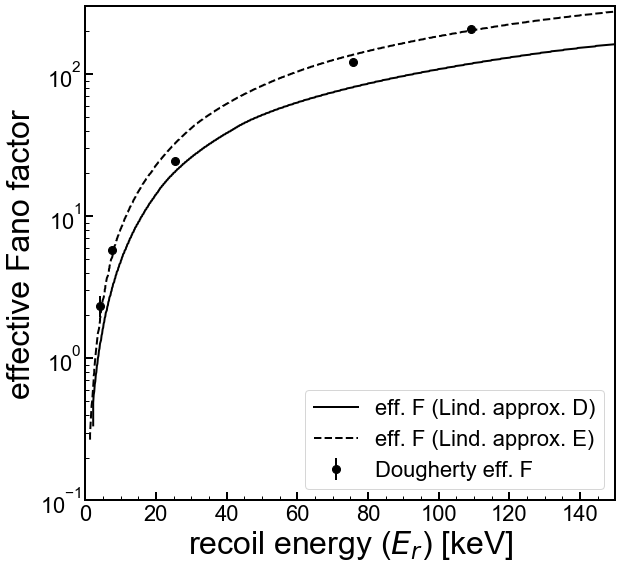

In [23]:
#set up a plot

fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

xmax=10

ax1.errorbar(ddata_e,ddata_fluct_F,yerr=[ddata_fluct_F_err,ddata_fluct_F_err], marker='o', markersize=8, \
             ecolor='k',color='k', linestyle='none', label='Dougherty eff. F', linewidth=2)


#ax1.plot (X, diff, 'm-', label='Thomas-Fermi (newgrad)')
#ax1.plot (Esi(epr), 100*np.sqrt(f_Omega2_eta2(epr))*ylindv(1000*Esi(epr)), 'g-', label='$\Omega/\epsilon$ (NAC III approx. D)')
ax1.plot (Esi(lindD_e), F_D, 'k-', label='eff. F (Lind. approx. D)')
ax1.plot (Esi(lindE_e), F_E, 'k--', label='eff. F (Lind. approx. E)')




ax1.set_yscale('log')
ax1.set_xscale('linear')
ax1.set_xlim(Esi(0), 150)
ax1.set_ylim(0.1,300)
ax1.set_xlabel('recoil energy ($E_r$) [keV]',**axis_font)
ax1.set_ylabel('effective Fano factor',**axis_font)
#ax1.grid(True)
#ax1.xaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()